<p style="font-family:Muro;font-weight:bold;font-size:55px;margin:5px 0px 50px 0px;color:#A04720">Social Graphs 2021</p>
<p style="font-family:Verdana;font-weight:light;font-size:35px;margin:5px 0px 10px 0px;color:#ffffff">Assignment two</p>

___


# **Part 0: Building the network**

To create our network, we downloaded the Zelda Wiki pages for all characters in BotW (during Week 4) and linked them via the hyperlinks connecting pages to each other. To achieve this goal we have used regular expressions!

* Explain the strategy you have used to extract the hyperlinks from the Wiki-pages, assuming that you have already collected the pages with the Zelda API.
    * In order to extract the hyperlinks from the Wiki-pages, the <code>bs4</code> module, also called <code>BeautifulSoup</code> was used. Firstly, a characterlist was created by looping over the different pages for allies, enemies and bosses, adding their role at the same time with a combination of the <code>request</code> library and <code>BS4</code> for manipulating HTML/CSS elements. Afterwards, when the list of character names and their role had been created, this was used as a base for finding the rest of the data. Looping over this list, send a request to the relevant wiki-page for the designated character, and storing the source code in a variable. When the variable had been created, <code>BS4</code> was again used to capture all elements containing the <code>a</code> HTML attribute, that constitutes a word is linking to another page, checking whether this element matches any of the characters in the character list, and if they do - add them to an edgelist that was appended to the dataframe. For the role and gender, the infobox was identified with <code>BS4</code> and noted down, if present.

* Show the regular expression(s) you have built and explain in details how it works.
    * As mentioned, no regex was used in obtaining the relevant information from the wikipages, however if that approach were being used, the regex would look like this:
        * **Step 1:** Using the RegEx: <code>{{(?:Term|Plural)\|BotW\|(.*?)\|link}}</code> to capture the most generic links.
            * A lot of the links follow a standard format of {{Term|BotW|---}} where "---" is the character name, meaning that {{Term|BoTw|}} will be standard for all of them.
            * Some links have "Plural" instead of "Term", so the (?:) captures both
            * This means that (.*?) must be used following this code, to capture everything coming after.
            * \ being used to escape characters to show they are part of the actual String.
            * \|link, stops capturing at this place, only returning the character links
        * **Step 2:** Using the RegEx: <code>\[\[(.*?)\]\]</code> to capture the redirecting links
            * The redirecting links follow a standard format of [[---]] where "---" is the character name, meaning .*? in the RegEx will capture everything between those lines.
            * Again, \ being used to capture characters that are part of the string.
        * **Step 3:** Using the RegEx: <code>\n|race= {{Term\|BotW\|(.*?)\|link}}</code> to capture the race of the character
            * The \n captures those on a new line
            * Follows a pattern of {{Term\|BotW\|---\|link}} where "---" is the characters race, ensures to capture everything in-between
        * **Step 4:** Using the RegEx: <code>\n|gender= (.*?)\<</code> to capture the gender of the character
            * Will capture everything following gender= and stopping at the next < symbol
        * **Step 5:** When capturing character names, they must be checked up against the character list to ensure the link leads to a real character in the game. If no character name, role or gender is found, append <code>None</code> to the corresponding row within the dataframe.

# **Part 1: Network visualization and basic stats**

Importing the relevant libraries

In [385]:
#Libs
#Everything runs on Python 3.7.10, Conda distribution

import pandas as pd
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm
from fa2 import ForceAtlas2

import ast, powerlaw, nltk, re, json, math, os, glob, io, pickle, urllib, requests, string

import community as community_louvain
from collections import Counter
from collections import defaultdict
import urllib.request
from wordcloud import WordCloud
from nltk.corpus import stopwords
sw = stopwords.words('english')
tk = nltk.WordPunctTokenizer()
from tqdm.notebook import tqdm
from pathlib import Path
from nltk import FreqDist
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from matplotlib.pyplot import errorbar
from PIL import Image

import warnings
warnings.filterwarnings("ignore")

In [386]:
#Issues with community, reloading will fix
from importlib import reload
reload(community)

<module 'community' from 'C:\\Users\\Dr. Vjotel Frantzwag\\anaconda3\\lib\\site-packages\\community\\__init__.py'>

## Data preprocessing

In [387]:
#Loading in the already generated dataset
df = pd.read_csv("bowFull.csv")
#Removing an undesired column
df.drop("Unnamed: 0", inplace=True, axis=1)
#Checking the datatypes
df.dtypes


Name      object
Role      object
Race      object
Gender    object
Edges     object
dtype: object

Upon inspecting the datatypes, it can be noted that the edges column has the dtype "object", when in reality it is a list:

In [388]:
df['Edges'][:3]

0                ['Link', 'Nazbi', 'Savelle', 'Yammo']
1                                           ['Baumar']
2    ['Ena', 'Hylia', 'Malanya', 'Konba', 'Chork', ...
Name: Edges, dtype: object

To be able to process this data correctly, the <code>ast.literal_eval()</code> function is casted on the PD series to turn the datatype into a list

In [389]:
df.Edges = df.Edges.map(lambda a: ast.literal_eval(a) if pd.notnull(a) else a)

Double-checking that the column has been transformed into a proper list, by accessing the elements through slicing

In [390]:
#Should return "Nazbi"
df['Edges'][0][1]

'Nazbi'

However, pure lists doesn't work well with <code>networkx</code>, which means that each element in the 'Edges' columns needs to be transformed into each own row for the specific characters. This can be done using <code>df.explode()</code>

In [391]:
df = df.explode("Edges")

In [392]:
#Inspecting the first four element to ensure column has been correctly transformed
df.head(4)

,Name,Role,Race,Gender,Edges
0,Baddek,Ally,Hylian,Male,Link
0,Baddek,Ally,Hylian,Male,Nazbi
0,Baddek,Ally,Hylian,Male,Savelle
0,Baddek,Ally,Hylian,Male,Yammo


## Building the network

The <code>.from_pandas_edgelist()</code> function takes in a dataframe, a source (nodes) and a target (edges). Adding the additional argument, <code>create_using=nx.DiGraph()</code> will ensure the network is constructed with a directional graph, so bot inwards- and outwards degrees can be counted.

In [393]:
G = nx.from_pandas_edgelist(df, 'Name', 'Edges', create_using=nx.DiGraph())

In [394]:
#Noting that there is a "nan" node that must be removed since these don't lead to a page
list(set(list(G.nodes())))[0]

nan

In [395]:
G.remove_node(np.nan)

### Extracting the Giant Connected Component (GCC)

The code below extracts the GCC from the network, i.e. the "central hub" where the most nodes are connected, effectively removing characters that are not meaningful to the end case. This can be a character who is only connected to their horse, which wouldn't provide much information to the overall network.

In [396]:
GCC = G.subgraph(sorted(nx.weakly_connected_components(G), key=len, reverse=True)[0])

print(f"Nodes that were removed: {len(G.nodes()) - len(GCC.nodes)}")


Nodes that were removed: 116


## Exercise **1a**: Stats 

    * What is the number of nodes in the network?
    * What is the number of links?
    * Who is the top connected character in BotW? (Report results for the in-degrees and out-degrees). Comment on your findings. Is this what you would have expected?

In [397]:
print(f"Nodes in the network: {len(GCC.nodes())}")
print(f"Number of links in the network: {len(GCC.edges())}")
topConnectedIn = sorted(GCC.in_degree, key=lambda x: x[1], reverse=True)[0]
print(f"The top connected character based on in-degrees is: {topConnectedIn[0]}, who has {topConnectedIn[1]} inwards connections.")
topConnectedOut = sorted(GCC.out_degree, key=lambda x: x[1], reverse=True)[0]
print(f"The top connected character based on out-degrees is: {topConnectedOut[0]}, who has {topConnectedOut[1]} outwards connections.")

Nodes in the network: 540
Number of links in the network: 2074
The top connected character based on in-degrees is: Link, who has 404 inwards connections.
The top connected character based on out-degrees is: Lizalfos, who has 28 outwards connections.


    Who are the top 5 most connected allies (again in terms of in/out-degree)?



In [398]:
#Creating a function that takes in a dataframe that is modified to only contain the relevant role, and the GCC
def findTop(inputDF, inputNetwork):

    inDegree = list(sorted(inputNetwork.in_degree, key=lambda x: x[1], reverse=True))
    outDegree = list(sorted(inputNetwork.out_degree, key=lambda x: x[1], reverse=True))

    #Sub function for calculating the top five characters within the given role
    def topFive(inputList):
        counter = 0
        placeHolderList = []
        for value in inputList:
            if value[0] in list(inputDF['Name']):
                placeHolderList.append(value)
                counter += 1
            if counter == 5:
                return placeHolderList
            
    inDegreeList = topFive(inDegree)
    outDegreeList = topFive(outDegree)

    #Returning both in- and out degree for the relevant characters
    return inDegreeList, outDegreeList

#Function for printing out the relevant information
def printTop(inputList, types, inOut, amount=5):

    print(f"\n-----Top {amount} {types} with {inOut} degree------")
    
    for i, character in enumerate(inputList):
        print(f"#{i}: {character}")


With the relevant functions created, creating a seperate DataFrame with only characters with the role *ally* will be selected, and printed.

In [399]:
onlyAllies = df.loc[df['Role'] == "Ally"]

topIn, topOut = findTop(onlyAllies, GCC)


printTop(topIn, "allies", "inwards")
printTop(topOut, "allies", "outwards")


-----Top 5 allies with inwards degree------
#0: ('Link', 404)
#1: ('Hylia', 67)
#2: ('Princess Zelda', 33)
#3: ('Mipha', 25)
#4: ('Riju', 23)

-----Top 5 allies with outwards degree------
#0: ('Link', 16)
#1: ('Impa', 15)
#2: ('Traysi', 14)
#3: ('Princess Zelda', 12)
#4: ('Daruk', 11)


Again, the same for enemies and bosses.

In [400]:
onlyEnemies = df.loc[(df['Role'] == "Enemy") | (df['Role'] =="Boss")]

topIn, topOut = findTop(onlyEnemies, GCC)

printTop(topIn, "enemies/bosses", "inwards")
printTop(topOut, "enemies/bosses", "outwards")



-----Top 5 enemies/bosses with inwards degree------
#0: ('Calamity Ganon', 105)
#1: ('Lizalfos', 27)
#2: ('Bokoblin', 26)
#3: ('Hinox', 23)
#4: ('Master Kohga', 20)

-----Top 5 enemies/bosses with outwards degree------
#0: ('Lizalfos', 28)
#1: ('Hinox', 21)
#2: ('Stone Talus', 20)
#3: ('Moblin', 18)
#4: ('Windblight Ganon', 17)


    Plot the in- and out-degree distributions.


Text(0.5, 0.98, 'Figure 1, distribution of nodes with inward and outward degrees in the directed Zelda Network')

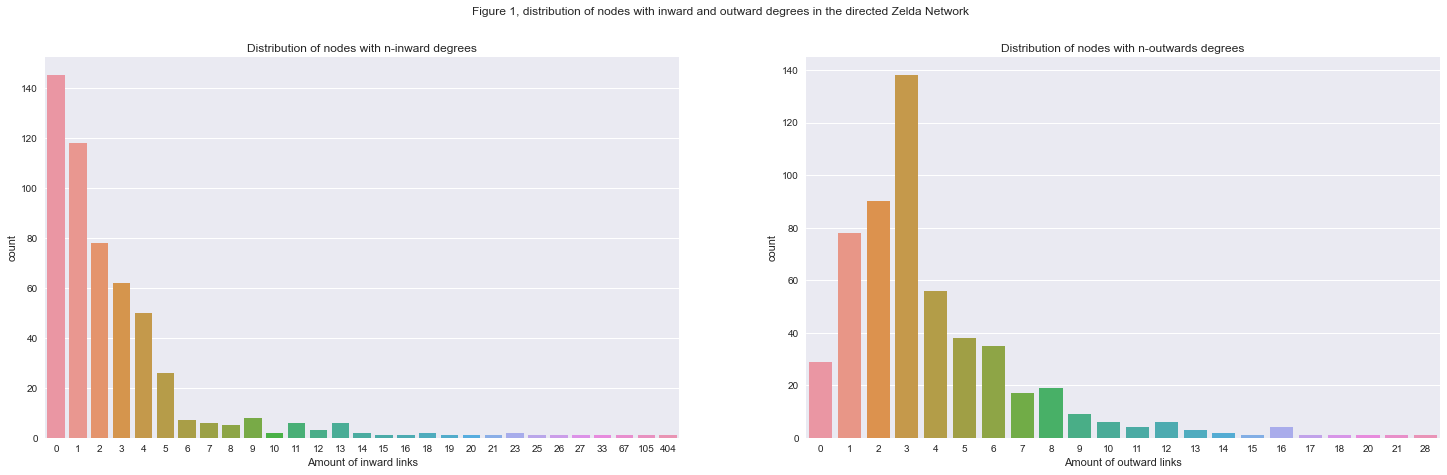

In [401]:
#Dividing into two subplots to more easily see the differences
fig, axs = plt.subplots(1, 2)
fig.set_size_inches(25,7)


sns.countplot(list(dict(GCC.in_degree).values()), ax=axs[0])
axs[0].set_title("Distribution of nodes with n-inward degrees")
axs[0].set_xlabel("Amount of inward links")

sns.countplot(list(dict(GCC.out_degree).values()), ax=axs[1])
axs[1].set_title("Distribution of nodes with n-outwards degrees")
axs[1].set_xlabel("Amount of outward links")



    What do you observe?

* Inward degree distribution
    * The inward degree distribution follows a power law like pattern, where there is a significant number of characters with none-to-small amount of inward links, and extremely few of the larger occurences. The reason for the unbelivable high amount of characters with zero inwards degrees, is that many characters in the game are rather insignificant for the main story and therefore not mentioned in other characters' pages. Another factor can also be those characters that are so insignificant that they do not have a designated wiki page with information, e.g. <a href="https://zelda.fandom.com/wiki/Monya_Toma#Breath_of_the_Wild">Monya Toma</a>
* Outward degree distribution
    * The outward degree distribution is a bit different, having zero characters with no outward connections, looking more similar to a Poisson distribution. The reason for this is not unexpected, as the characters who would not point to another page would be removed when creating the GCC. This in turn results in many characters having one link, as there wouldn't be the need for a wikipedia page if the character would be so insignificant that they didn't connect to any other characters. The distribution is also less extreme, with the amount of outward links being incremental.


**Can you explain why the in-degree distribution is different from the out-degree distribution?**

To summarize, the difference can be explained by a combination of factors. The generation of the GCC, eliminated all "isolated nodes" and only kept the ones that had at least one outward connections. Additionally, as is stated by the power law, a network usually consists of a few central nodes, or "hubs", that has few outward links but that most other characters are connected to. Especially in video games where you have protagonists and antagonists, these characters will be extremely central and interacts with most characters at a given point. While these interactions can be central for the smaller characters, in explaining their background, they are insignificant for main characters stories, and the direction will then be one-sided.


    Find the exponent of the degree distribution (by using the powerlaw package) for the in- and out-degree distribution.


In [402]:
def powerlaw_exponent(degreeList):
    gamma = powerlaw.Fit(degreeList).alpha
    return gamma

In [403]:
inDegree = powerlaw_exponent(list((dict(GCC.in_degree).values())))
outDegree = powerlaw_exponent(list((dict(GCC.out_degree).values())))

Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values


In [404]:
print(f"""
Exponent for the in-degree: {inDegree} 
Exponent for the out-degree: {outDegree} 
""")


Exponent for the in-degree: 2.729779372119334 
Exponent for the out-degree: 4.081957099901511 



    What does it say about our network?

The powerlaw exponent, $\gamma$, is found to be $\gamma \approx 2.7$ for the in-degree and $\gamma \approx 4$ for the out-degree. According to Barbasi (Barabasi, 4.7), this would put the in-degree network in the scale free regime, and the out-degree in the random network regime. This was expected, as multiple hubs were noticed in the in-degree network, opposed to none in the out-degree network, as is common in these networks:
> In a random network most nodes have comparable degrees and hence hubs are forbidden. Hubs are not only tolerated, but are expected in scale-free networks (Image 4.6). Furthermore, the more nodes a scalefree network has, the larger are its hubs. Indeed, the size of the hubs grows polynomially with network size, hence they can grow quite large in scalefree networks. In contrast in a random network the size of the largest node grows logarithmically or slower with N, implying that hubs will be tiny even in a very large random network. (Barbasi, 4.3)

    Compare the degree distribution of the undirected graph to a random network with the same number of nodes and probability of connection p.

When generating an Erdos Renyi graph, the parameters needed are $n$, for the amount of nodes the network should have, and $p$, the probability that a node is connected. These can be found by using the already generated GCC.


In [405]:

N = len(GCC.nodes())
k = sum(dict(GCC.degree).values()) / len(GCC.nodes())
p = k/(N-1)

E = nx.erdos_renyi_graph(N, p)



Now that a random generated network with the same specifications have been created, the degree distributions can be plotted to measure them against each other.

Text(0.5, 0.98, 'Figure 2, Comparing the overall Zelda network with an ER network of same size')

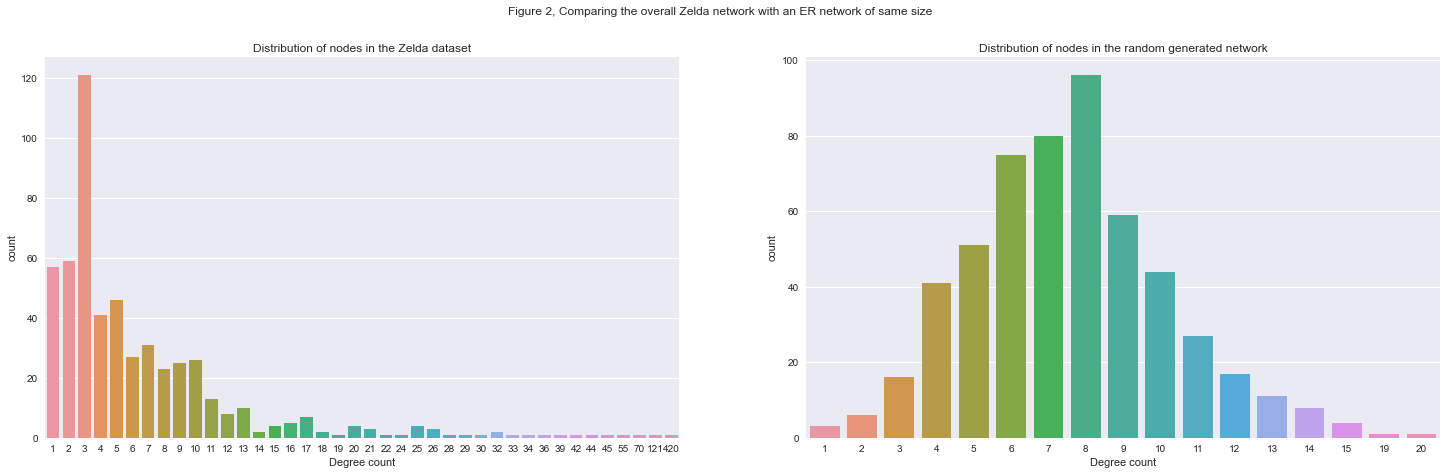

In [406]:
fig, axs = plt.subplots(1, 2)
fig.set_size_inches(25,7)


sns.countplot(list(dict(GCC.degree).values()), ax=axs[0])
axs[0].set_title("Distribution of nodes in the Zelda dataset")
axs[0].set_xlabel("Degree count")

sns.countplot(list(dict(E.degree).values()), ax=axs[1])
axs[1].set_title("Distribution of nodes in the random generated network")
axs[1].set_xlabel("Degree count")

fig.suptitle("Figure 2, Comparing the overall Zelda network with an ER network of same size")

    Comment your results.

Comparing the zelda dataset with the random generated ER network, the differences are apparent. Firstly, the Zelda dataset follows a Powerlaw distribution and will therefore be right-tailed, where most characters have few edges, as well as some minor hubs at the very end that have a high degree count, since they are central to the video game. On the other hand, the random generated ER network will follow a normal distribution, where most of the nodes will be centered around the mean, with some outliers on both sides. 

# Exercise 1B

    * Create a nice visualization of the total (undirected) network:

As is mentioned in the task description, the network will be transformed into an undirected one to make the graph more visually appealing and easier to comprehend.

In [407]:

V = GCC.to_undirected()

    Color nodes according to the role;

In [408]:
def generateColorList(graphObject):

    dfNotExploded = pd.read_csv("bowFull.csv")
    nodeList = list(graphObject.nodes())

    colorList = [dfNotExploded.loc[dfNotExploded['Name'] == node]['Role'].values[0] for node in nodeList]

    return colorList

def getNodeColors(graph):

    colorMap = []
    for role in graph:
        if role == "Ally":
            colorMap.append("#50c878")
        elif role == "Enemy":
            colorMap.append("#ff9100")
        else:
            colorMap.append("#F42C4A")
    return colorMap

    Scale node-size according to degree;


In [409]:

def getNodeSize(graph):
    degrees = dict(graph.degree)
    return [v*5 for v in degrees.values()]


    Whatever else you feel like that would make the visualization nicer.

Additional steps that have been included to make the graphs nicer, is the function below that adds colorization between edges based on the roles of the edges.
* **Green:** If the relationship is between two allies
* **Red:** If the relationship is between two enemies/bosses
* **Orange:** If the relationship is between an ally or an enemy/boss


In [410]:
def edgeColor(G):
    colorMap = []
    fullDF = pd.read_csv("bowFull.csv")
    edgeDict = G.edges()
    for edge in edgeDict.keys():
        role1 = str(fullDF.loc[fullDF['Name'] == edge[0]]['Role'].values)
        role2 = str(fullDF.loc[fullDF['Name'] == edge[1]]['Role'].values)
        def removeUnwantedChars(_string):
            _string = _string.replace("[","")
            _string = _string.replace("'","")
            _string = _string.replace("]","")
            return _string

        role1 = removeUnwantedChars(role1)
        role2 = removeUnwantedChars(role2)

        if role1 == role2 == "Ally":
            colorMap.append("green")
        elif role1 == role2 == "Enemy" or role1 == role2 == "Boss" or role1 == "Boss" and role2 == "Enemy" or role1 == "Enemy" and role2 == "Boss":
            colorMap.append("red")
        else:
            colorMap.append("orange")

    return colorMap

Another additional step that has been added to the visualization, is to find the top ten connected characters and plot the labels to more easily comprehend the patterns.

In [411]:
topTenConnected = list(dict(sorted(V.degree, key=lambda x: x[1], reverse=True)[:10]).keys())
labels = {}

for node in V.nodes():
    if node in topTenConnected:
        labels[node] = node

100%|██████████| 500/500 [00:04<00:00, 105.29it/s]


BarnesHut Approximation  took  0.77  seconds
Repulsion forces  took  3.74  seconds
Gravitational forces  took  0.03  seconds
Attraction forces  took  0.02  seconds
AdjustSpeedAndApplyForces step  took  0.09  seconds


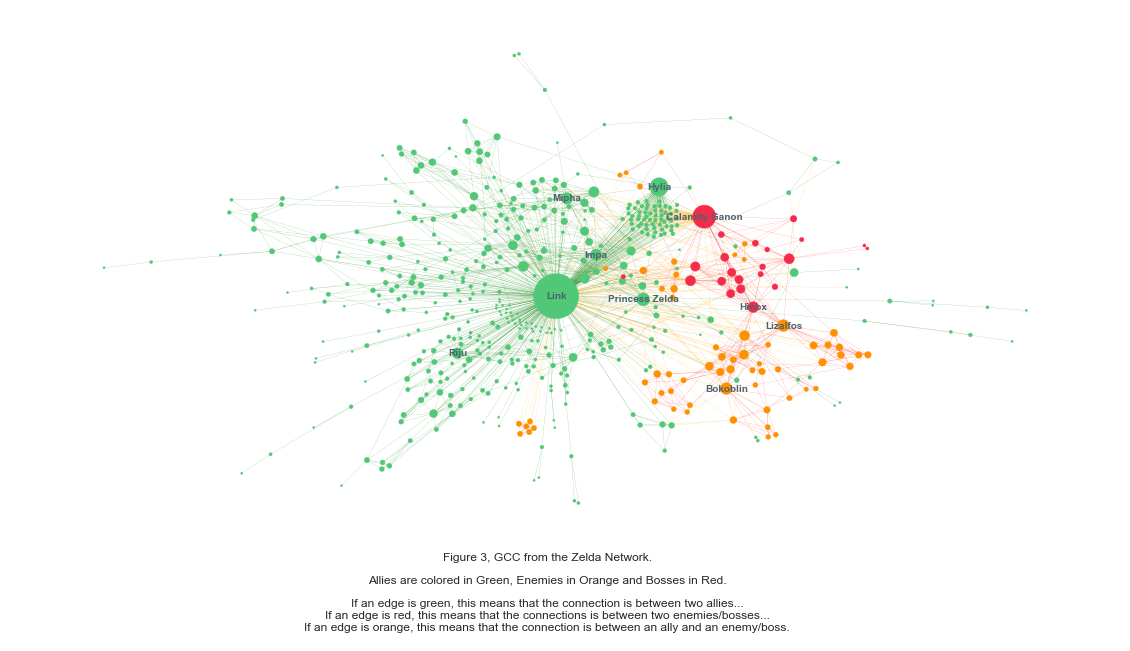

In [412]:
fig, ax = plt.subplots()
fig.set_size_inches(20,10)

positions = ForceAtlas2().forceatlas2_networkx_layout(V, pos=None, iterations=500)
nx.draw_networkx_nodes(
    V,
    positions,
    node_size=getNodeSize(V),
    node_color=getNodeColors(generateColorList(V)))
nx.draw_networkx_edges(
    V,
    positions,
    width=0.1,
    edge_color=edgeColor(V)
    )

nx.draw_networkx_labels(V, positions, labels, font_size=10, font_color="#4E656D", font_weight="bold")

#This needs to be off, for the caption to be within the figure
plt.axis('off')
caption = '''
Figure 3, GCC from the Zelda Network.

Allies are colored in Green, Enemies in Orange and Bosses in Red.

If an edge is green, this means that the connection is between two allies...
If an edge is red, this means that the connections is between two enemies/bosses...
If an edge is orange, this means that the connection is between an ally and an enemy/boss.
'''
plt.figtext(0.5, 0, caption, wrap=True, horizontalalignment='center', fontsize=12)
plt.show()


    Describe the structure you observe. Can you identify nodes with a privileged position in the network? Do you observe chains of connected nodes? Do you see any interesting group of nodes (can you guess who's involved)?

Firsty, the fact that Link, the protagonist, is at the center of the network is not a surprise. Being the protagonist, he will most definitely be in contact with most character in the game during his journey. Another interesting pattern that emerges, is the centrality of the hubs. Plotting the labels of the ten most well-connected characters highlighted their position in the network, and displaying the fact that most of these central characters are in close proximity to their roles. Especially interesting, is Princess Zelda, which seems to be in the middle between the allies and the enemies/bosses, this might be explained by her being an ally and her interactions with evil characters, e.g. when Ghirahim kidnappes her. Other than the top four largest hubs, i.e. Link, Calamity Ganon, Lizalfos and Princess Zelda, the edges between characters seem to be fairly uniform. Characters like Mipha and Riju seem to only have green edges, meaning they are only connected with Allies, and have no interactions with the evil characters.


# **Part 2: Word-clouds**

<code>Create your own version of the word-clouds (from lecture 7). For this exercise we assume you know how to download and clean text from the ZeldaWiki pages.</code>

In order to more easily process the data, a <code>.get_json</code> function is created that calls the API Url of the designated characters, and stores the informat in a json object

In [413]:
#Loading the dataset and creating a list of all the names to  loop over
df_characters = pd.read_csv('ZeldaBotW_nodes_w_attributes_enriched.csv')
names = df_characters['Name'].tolist()

#In the wikipage, 'Ancient Oven' is the title of the character, which is named 'Cherry' in the .csv file, so this line of code fixes that.
names2 = ['Ancient Oven' if x == 'Cherry' else x for x in names]
#Replacing space with underline to more neatly store in the text file
names3 = [x.replace(" ", "_") for x in names2]

def get_json(title):
    title1 = urllib.parse.quote_plus(title)
    baseurl = "https://zelda.fandom.com/api.php?"
    action = "action=query"
    title = f'titles={title1}'
    content="prop=extracts&exlimit=1&explaintext"
    dataformat ="format=json"
    query = "{}{}&{}&{}&{}".format(baseurl, action, content, title, dataformat)
    wikiresponse = urllib.request.urlopen(query)
    wikidata = wikiresponse.read()
    wikitext = wikidata.decode('utf-8')

    return title1, list(json.loads(wikitext)['query']['pages'].values())[0]['extract']

The function below is utilized to generate all the characters' text files, but is commented out as this is already included in the .zip file of the project (in the /pages folder)

In [414]:
def write_to_txt(title, text):
    text_file = open(f"pages\{title}.txt", "w")
    n = text_file.write(text)
    text_file.close()

### Uncomment if you want to generate all the textfiles within the directory (not necessary as they are included in the .zip)
# for name in names3:
#    info = get_json(name)
#    write_to_txt(info[0], info[1])

Now that all the character pages are downloaded and neatly stored in the /pages folder, they are going to be cleaned for increased readability. Starting off, all of the headers, e.g. ('== Biography ==') etc., and punctiations, are removed using RegEx. Additionally, everything that comes after the '== Nomeclature ==' part, is removed as it can be classified as redundant information. Lastly, all the text is split into tokens and looped through them to remove character names and stopwords, the tokens are then lemmatized. 


In [415]:
def cleaned_txt(filename):
    with open(f"pages\{filename}", encoding="utf-8") as f:
        contents = f.read()
    f.close()

    #Replacing all newlines with space
    new_contents = contents.replace('\n', ' ')

    #Regex functions to removed the aforementioned characters
    res1 = re.sub(r"== Nomenclature ==.*", " ", new_contents)
    res2 = re.sub(r'\==[^====]*\==',  '', res1)
    res3 = re.sub(r'[^\w\s]', '', res2)

    #Generating the tokens
    tokens = tk.tokenize(res3)

    #Looping over all the character names
    for name in names:
        try:
            while True:
                tokens.remove(name)
        except ValueError:
            pass
    
    #Removing all the stopwords
    new_tokens = [token.lower() for token in tokens]
    for word in sw:
        try:
            while True:
                new_tokens.remove(word)
        except ValueError:
            pass
    
    #Generating the lemmatizer and returning the output
    wnl = nltk.WordNetLemmatizer()
    output = [wnl.lemmatize(t) for t in new_tokens]
    
    return output

With the previously generated tokenizations of the text, the method below combines the individual character's text into a list.

In [416]:
def combine_and_convert(titles_input):
    all_tokens = []
    for title in titles_input:
        all_tokens.append(cleaned_txt(title))
    return sum(all_tokens, [])


Character's wikipages have been cleansed and combined, which means the actual work can begin. Starting off, five 'texts' are created, one for each of the five champions of Hyrule:
* Hylian
* Zora
* Goron
* Gerudo
* Rito 

In [417]:
#Generating a document based on all the characters within a race
def make_text(race):
    names = [x.replace(" ", "_") for x in df_characters[df_characters['Race'] == race]['Name'].tolist()]
    titles = [urllib.parse.quote_plus(x) + '.txt' for x in names]
    return nltk.Text(combine_and_convert(titles))

#One document for each of the five aforementioned champions of Hyrule
hylian = make_text('Hylian')
zora = make_text('Zora')
goron = make_text('Goron')
gerudo = make_text('Gerudo')
rito = make_text('Rito')


Combining all the races into a list for later use in the idf.

In [418]:
texts = [hylian, zora, goron, gerudo, rito]

## Generating the TC-IDF

A total of three methods are created:
* One for generating the TC's
* One for computing the IDF for every word across the five documents
* One for generating the TC-IDF



In [419]:
def tc(text):
    tc = {}
    for key, value in nltk.FreqDist(text).items():
        tc[key] = value
    return tc

def idf(texts):
    text = nltk.TextCollection(texts)
    idf = {}
    for word in text:
        idf[word] = text.idf(word)
    return idf

idfs = idf(texts)

def tc_idf(text):
    tc_ = tc(text)
    tc_idf = {}
    for word in text:
        tc_idf[word] = int(math.ceil(idfs[word])) * tc_[word]
    return tc_idf

## Visualizing the wordclouds

To reiterate: five wordclouds for each of the five champions have been created, and will now be visualized below with the more popular words being larger in size.

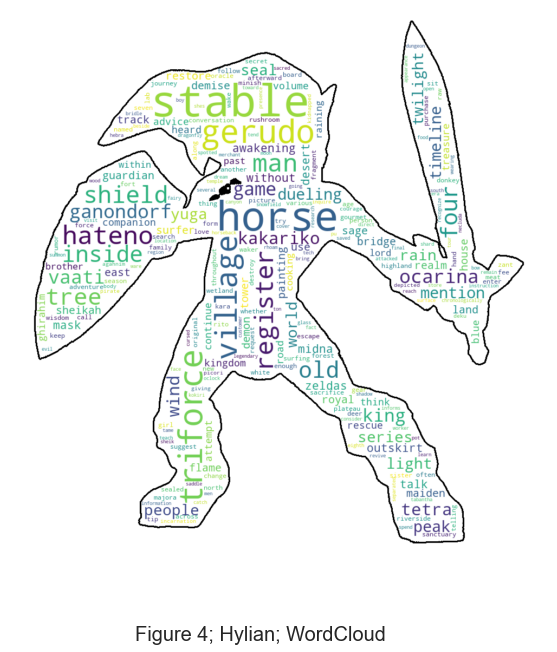

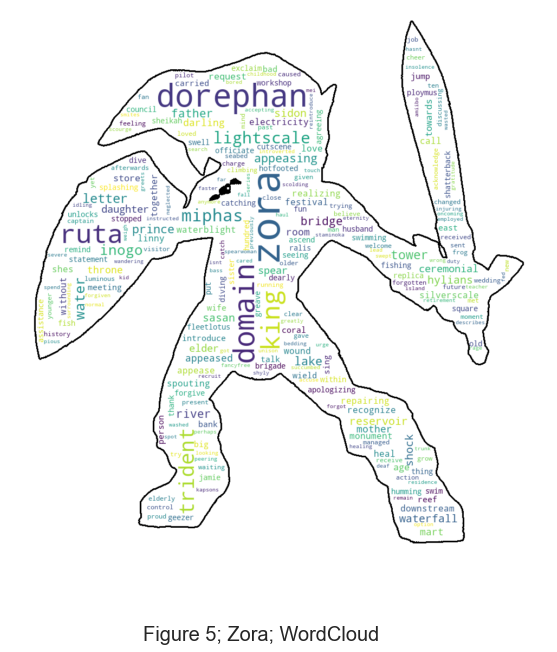

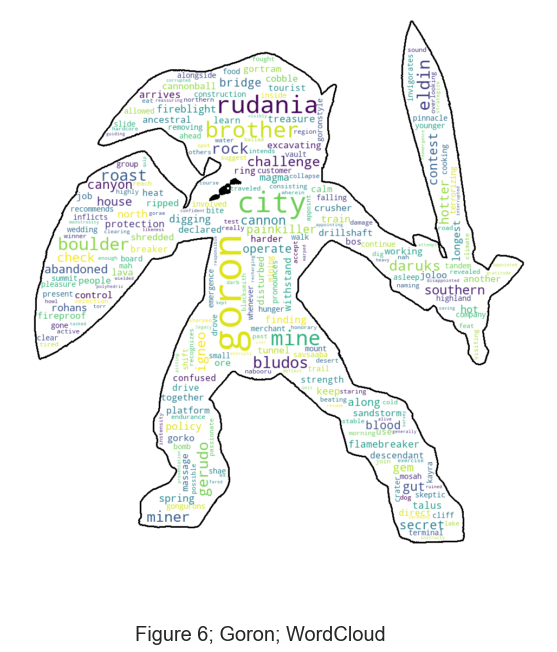

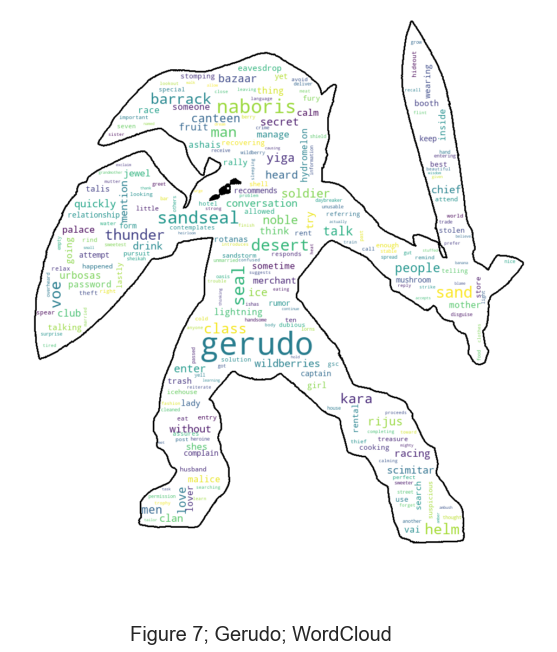

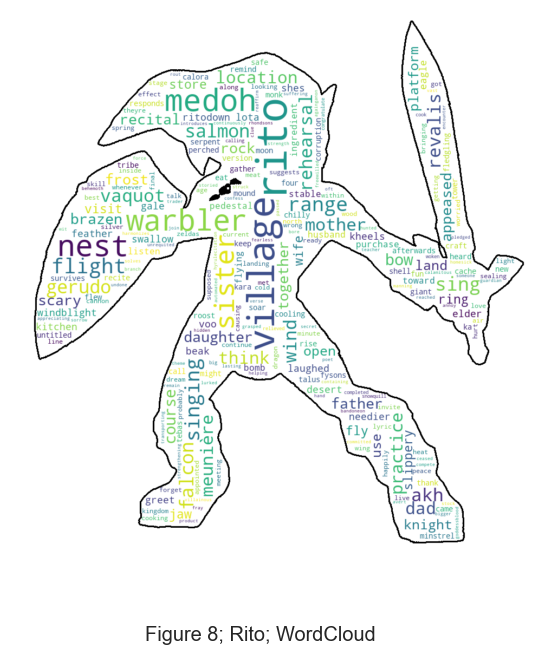

In [420]:
from PIL import Image
link_mask = np.array(Image.open("link.png"))
characterNames = ["hylian", "zora", "goron", "gerudo", "rito"]

def make_wordclouds():
    for i, text in enumerate(texts):
        string = ""
        for key, value in tc_idf(text).items():
            string += ((key  + " ") * value)
        
        wordcloud = WordCloud(max_words=250, background_color="white", collocations=False, mask = link_mask, contour_width=3, contour_color='black').generate(string)
        plt.figure(figsize=[20,10])
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis("off")
        plt.figtext(0.5, 0, f"Figure {3+(i+1)}; {characterNames[i].capitalize()}; WordCloud", wrap=True, horizontalalignment='center', fontsize=20)
        plt.show()

make_wordclouds()



* Comment on your results:
    * The Hylians are all about stables, horses, and the village and are maybe more home-loving than the other races. They also seem to have some connections to the Gerudos and cares a lot about the tri-force. 
    * The Zora care a lot about their king, Dorephan, and his trident. His throne room is in Zora's Domain, which is also prevalent. 
    * The Gorons are all about challenges and contests. They are a rock people, so they are described by boulders, miner, gems and rocks.
    * The Gerudo are female pirates who live in the desert, so the words that describe them are sand and desert. They also are connected with the sand seal, which are creatures who live in the desert. 
    * The Rito are very close to their village. Some words that describe them are flight, nest, singing, falcon, mother, sister. This suggest that they are a bird people with close family relations. This coincides with the wiki page.

# **Part 3: Communities and TF-IDF**

In the following segment, the Zelda-network that was created in Part 1 will be used to find communities and computing their associated TF-IDF.

* <code>Explain the Louvain algorithm and how it finds communities in a network.</code>
    * The Louvain algorithm creates the communities by optimizing the modularity of the network. First, it creates relative small communities by optimizing the modularity on small parts of the network. It individually chooses nodes, and calculates change in modularity, and does this for every node and creates small communities. It then uses nodes in the same community and builds a new network where the nodes are the communities (nodes in the same community becomes one node). It then does tihs iteratively until it gets max modularity.
* <code>Explain how you chose to identify the communities: Which algorithm did you use?</code>
    * We used the Louvain algorithm, which comes included as a python package in the form of community.best_partition(). Here, best_partition is the partition with highest modularity (the highest partition of the dendrogram generated by the Louvain algorithm).

Following, the <code>best_partition()</code> have been implemented method on the Zelda-graph. 

The following code answers these questions:
>   * <code>How many communities did you find in total?</code>
>   * <code>Compute the value of modularity with the partition created by the algorithm.</code>
>   * <code>Plot the distribution of community sizes.</code>
    
    

We found 21 communities in total.
The modularity of the partition created is 0.5677156058430189.


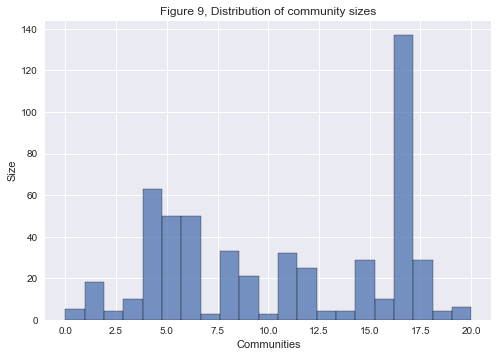

In [421]:

#Using the .best_partition method of the louvain algorithm, randomize is set to false so the results stay uniform
partition = community_louvain.best_partition(V, randomize=False)

#Counting the amount of communities
count = len(set(partition.values()))

#As well as the modularity
modu = community_louvain.modularity(partition, V)

#Printing out the answers to these two questions.
print(f"We found {count} communities in total.")
print(f"The modularity of the partition created is {modu}.")

data = list(partition.values())
five_largest = []
for elem in Counter(data).most_common(5):
    five_largest.append(elem[0])

#Plotting the distribution
values, bins = np.histogram(list(partition.values()), count)
sns.histplot(list(partition.values()), bins= count)
plt.title('Figure 9, Distribution of community sizes')
plt.xlabel('Communities')
plt.ylabel('Size')
plt.show()

A total of 21 communities was found in the Zelda network, with a modularity of the partition as **0.5677**, which suggests a really good partition (values close to 0 are worse).<br><br>

By the plot of the distribution above, it can be clearly noted that one of the communities is much larger the the others, and that there are also some small ones. <br><br>Next, the five largest ones will be analysed. The following code computes them. You can uncomment the for-loop with the print statements if you want to see the characters in the communities.

In [422]:

communities = defaultdict(list)
for k, v in partition.items():
    communities[v].append(k)

###     Uncomment this to see the characters within the communities   ####
###     This has been commented out, as the output took a lot of space in the notebook  ###      
#for i in five_largest:
#    print(f"Community {i}:")
#    print(communities[i])
#    print("-----------")

    There are many ways to calculate TF-IDF, explain how you've done it and motivate your choices.

Now it is time to compute TF-IDF. The TF was computed previously by first getting the frequency distribution from the method provided with nltk. This returns every word count. Then, each each term count (TC) needs to be divided with the number of words in the document, and then get the term frequency is acquired (TF). This is done for every word in each of the five communities. A built-in function could be used, but the frequency distribution is more precise and personalized.<br>
After this, the IDF is computed of all the words across the communities with nltk's built-in method <code>.idf()</code>. This method was chosen because it didn't feel like it was necessary to "re-invent the wheel". Now, you only need to multiply each word's TF in each document with the word's corresponding IDF. This results in TF-IDF for each word in each of the communities. They can then be sorted , and then slice of the top 5 words, which can be printed.


In [423]:
def tf_idf():
    #placeholder lists and dicts
    text_list = []
    text_dict = {}
    tf_total = {}
    print("Top five words according to tf for the five largest communities:\n")
    for i in five_largest:
        #Fixing the names and characters with different wiki names, than .csv
        names = [x.replace(" ", "_") for x in ['Ancient Oven' if x == 'Cherry' else x for x in communities[i]]]
        #Transforming the names into a title that can be used in the txt files
        titles = [urllib.parse.quote_plus(x) + '.txt' for x in names]
        #Retrieving the information from txt files and combines them
        text = nltk.Text(combine_and_convert(titles))


        text_list.append(text)
        text_dict[i] = text
        tf = {}
        #iterating through the frequency distributions of the term count
        for key, value in nltk.FreqDist(text).items():
            #Dividing by amount of words, to get term frequency
            tf[key] = value/(len(text))
        
        tf_total[i] = tf
        #Finding the top five
        top5 = (sorted(tf.items(), key = lambda x: x[1], reverse = True)[:5])

        #Printing
        print(f"Community {i}:")
        for i in range(len(top5)):
            #Printing the top five, using the end parameter to save notebook sapce
            print(f"{i+1}: {top5[i][0]}", end=", ")
        print("\n")
    

    #Combining all texts into one
    mytext = nltk.TextCollection(text_list)
    idf = {}
    #Iterating through each word and calculates the IDF for each word
    for word in mytext:
        idf[word] = mytext.idf(word)
        
    
    print("Top five words according to tf-idf for the five largest communities:\n")
    for j in five_largest:
        tf_idf = {}
        #Creating the td_idf score for the five largest communities
        for word in text_dict[j]:
            #Multiplying idf and tf to get the tf-idf
            tf_idf[word] = int(idf[word]) * tf_total[j][word]
        
        #Generating top five
        top5 = (sorted(tf_idf.items(), key = lambda x: x[1], reverse = True)[:5])

        #Prnting
        print(f"Community {j}:")
        for i in range(len(top5)):
            print(f"{i+1}: {top5[i][0]}", end=", ")
        print("\n")


    List the 5 top words for each community according to TF.
    List the 5 top words for each community accourding to TF-IDF

In [424]:
tf_idf()

Top five words according to tf for the five largest communities:

Community 17:
1: gerudo, 2: town, 3: tell, 4: wild, 5: say, 

Community 4:
1: shrine, 2: monk, 3: sheikah, 4: calamity, 5: breath, 

Community 5:
1: zelda, 2: princess, 3: hyrule, 4: time, 5: ganon, 

Community 6:
1: attack, 2: appear, 3: chuchus, 4: moblins, 5: fire, 

Community 8:
1: goron, 2: city, 3: breath, 4: wild, 5: character, 

Top five words according to tf-idf for the five largest communities:

Community 17:
1: barrack, 2: allowed, 3: drink, 4: rijus, 5: sandstorm, 

Community 4:
1: ostracism, 2: entered, 3: maag, 4: emblem, 5: kosah, 

Community 5:
1: maz, 2: koshia, 3: timeline, 4: raw, 5: pumpkin, 

Community 6:
1: lynels, 2: variant, 3: jelly, 4: chu, 5: wizzrobes, 

Community 8:
1: cannon, 2: dragonfly, 3: bludos, 4: wedding, 5: miner, 



    Are these words more descriptive of the community than just the TF? Justify your answer.

* Community 17: The most descriptive words from the TF are Gerudo and town. This suggests that many characters in the community are Gerudos, or are linked with them (e.g. the Hylians, as we learned from the word-clouds). The TF-IDF words however gives information about sandstorms and barracks. This may suggest that there are sand people and warriors in the community.
* Community 4: From the TF, there are a lot of descriptive words, which suggests connections to a sheika monk, and the event "the great calamity", along with shrines. From the TF-IDF, ostracism are words used to describe monks, and maag is a kind of shrine.
* Community 5: The TF has a combination of the most famous words in the Zelda series; Zelda, Princess, Hyrule and Ganon. This suggests that we have characters in the community with connections to main characters. The TF-IDF on the other hand gives us Maz Koshia, who is a monk, along with pumpkin, raw and timeline. 
* Community 6 has attack, chuchus, moblins and fire for TF. This may suggest that these characters are involved in a lot of combat. The TF-IDF has jelly, chu, lynels and wizzrobes, whom har all creatures. So, the characters in this community are involved with these creatures.
* Community 8. The TF only gives insight through the word Goron and City. The TF-IDF on the other hand give more specific words.

To summarize, the TF give a more generalized overview over the communities, and sometimes give a better explanation of the community, e.g. in community 4, where the words in the TF-IDF became a bit too character specific. The same can be said about Community 5. In conclusion, one can argue that both TF and TF-IDF give interesting insights, and complement each other by providing different "explanations" for the communities

# **Part 4: Sentiment of communities**

    Analyze the sentiment of the communities (lecture 8). Here, we assume that you've successfully identified communities. More tips & tricks can be found, if you take a look at Lecture 8's exercises.
    A couple of additional instructions you will need below:

    * We name each community by its three most connected characters.

    * Average the average sentiment of the nodes in each community to find a community level sentiment

Here's what you need to do (repeat these steps and report your results for both LabMT and VADER):

* <code>Calculate and store sentiment for every character</code>
* <code>Create a histogram of all character's associated sentiments.</code>
* <code>What are the 10 characters with happiest and saddest pages?</code>

## Sentiment analysis with LabMT


In [425]:
#tokenize the text for usage of LabMT
def tokenize_text(text, remove_wikisyntax=False):
    '''
    removing punctuation, removing stopwords, lemmatize, set to lower case, and tokenize the sentence
    '''
    if remove_wikisyntax:
        text = re.sub(r'\{\{.*?\}\}', '', text)
        text = re.sub(r'\[\[.*?\]\]', '', text)
        text = re.sub(r'\<.*?\>', '', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    tokens = word_tokenize(text)
    tokens = [token.lower() for token in tokens]
    tokens = [token for token in tokens if token not in stopwords.words('english')]

    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]

    return tokens

In [426]:
#as wikipages are written without a clear sentiment the dialogues from exercise week 8 are used instead of the processed character pages
url = "https://raw.githubusercontent.com/SocialComplexityLab/socialgraphs2021/main/files/CharactersDialogue.json"
resp = requests.get(url)
dialogues = json.loads(resp.text)

    Calculate and store sentiment for every character


In [427]:
#first the LabMT wordlist is downloaded and stored
sentiment_url = 'https://journals.plos.org/plosone/article/file?id=10.1371/journal.pone.0026752.s001&type=supplementary'
sentiment_values = pd.read_csv(sentiment_url, skiprows=3, delimiter='\t')[['word', 'happiness_average']]

#defining a function to calculate the characters sentiment
def calculate_pages_sentiment(graph):
    for character in graph.nodes():
        try:
            page_content = repr(dialogues[character])
        except FileNotFoundError:
            continue
        except KeyError:
            continue
        text = tokenize_text(page_content)
        sentiment = pd.DataFrame.from_dict(text)
        sentiment.columns = ['word']
        sentiment['count'] = sentiment.groupby('word')['word'].transform('count')
        sentiment = sentiment.merge(sentiment_values, on=['word'])
        if sentiment.empty:
            continue
        sentiment['mean'] = (sentiment['happiness_average'] * sentiment['count']).sum() / \
                            sentiment['count'].sum()
        graph.nodes[character]['sentiment'] = sentiment['mean'].mean()
    pickle.dump(graph, io.open('{zelda}_sent_graph.p', 'wb'))
    return graph

Using the nltk package to download all characters/words that shouldn't be included.

In [428]:

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to C:\Users\Dr. Vjotel
[nltk_data]     Frantzwag\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\Dr. Vjotel
[nltk_data]     Frantzwag\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\Dr. Vjotel
[nltk_data]     Frantzwag\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

With the relevant methods created, the zelda graph can be created by calling the method with the graph that was created in Part 1

In [429]:
#calling the function to compute the sentiments and storing them in zelda_graph
zelda_graph = calculate_pages_sentiment(V)

    Create a histogram of all character's associated sentiments.


In [430]:
#plotting the LabMT sentiment distribution
def plot_labmt_distribution(graph):
    sentiments = nx.get_node_attributes(graph, 'sentiment')
    title = "Sentiment distribution"
    caption = "Figure 10. The histogram is representing the distribution\nof all character's associated sentiments."
    values, bins = np.histogram([value for value in sentiments.values() if value is not np.nan],
                                10)
    plt.style.use("seaborn")
    plt.bar(bins[:-1], values, width=0.18)
    plt.title(title)
    plt.xlabel('Sentiment')
    plt.ylabel('Count')
    plt.grid()
    plt.figtext(0.5, -0.1, caption, wrap=True, horizontalalignment='center', fontsize=12)
    plt.show()

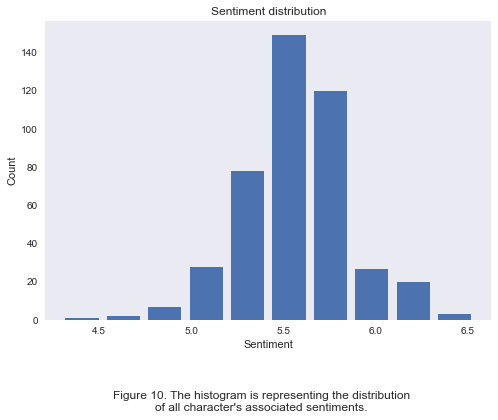

In [431]:
plot_labmt_distribution(V)

The histogram visualizes the distribution of sentiment amongst the characters in BotW, which is normally distributed with 5.5 as the most common sentiment. This indicates that the most words are neutral. Furthermore, a higher frequency of positive sentiments can be observed. Negative sentiments seem to be less occuring.

    What are the 10 characters with happiest and saddest pages?

## 10 characters with happiest and saddest pages

In [432]:
#storing the sentiments in a new dataframe
sentiments_df = pd.DataFrame.from_dict(dict(zelda_graph.nodes(data=True)), orient='index')
sentiments_df = sentiments_df.dropna(subset=['sentiment'])

### 10 happiest characters with LabMT

In [433]:
# happiest
sentiments_df.sort_values(by='sentiment', ascending=False).head(10)

,sentiment
Narah,6.655975
Baddek,6.546271
Malanya,6.439460
Kinov,6.404000
Shamae,6.398356
Hino,6.383672
Pepp,6.350529
Galli,6.347125
Bedoli,6.336063
Kayden,6.334928


### 10 saddest characters with LabMT

In [434]:
# saddest
sentiments_df.sort_values(by='sentiment', ascending=True).head(10)

,sentiment
Walton,4.406667
Kilton,4.701811
Dai,4.753822
Rik,4.878799
Pyle,4.882538
Sho,4.917213
Kenyo,4.993091
Jini,5.015040
Kotta,5.019375
Flaxel,5.035354


## Sentiment analysis with Vader

    Calculate and store sentiment for every character


In [435]:
#using Vader to compute the sentiments
analyzer = SentimentIntensityAnalyzer()
def calculate_pages_sentiment_Vader(graph):
    for character in graph.nodes():
        try:
            page_content = repr(dialogues[character])
        except FileNotFoundError:
            continue
        except KeyError:
            continue
        analyzer = SentimentIntensityAnalyzer()
        sentiment_dict = analyzer.polarity_scores(page_content)
        sentiment_dict = sentiment_dict.get("compound")
        graph.nodes[character]['sentiment'] = sentiment_dict
    pickle.dump(graph, io.open('{zelda}_sent_graph.p', 'wb'))
    return graph

In [436]:
#Utilizing the graph from part 1
zelda_graph_Vader = calculate_pages_sentiment_Vader(V)

    Create a histogram of all character's associated sentiments.


In [437]:
#plotting the Vader sentiment distribution
def plot_Vader_distribution(graph):
    sentiments = nx.get_node_attributes(graph, 'sentiment')
    title = "Sentiment distribution"
    caption = "Figure 11. The histogram is representing the distribution\nof all character's associated sentiments."
    values, bins = np.histogram([value for value in sentiments.values() if value is not np.nan],
                                10)
    plt.bar(bins[:-1], values, width=0.18)
    plt.title(title)
    plt.xlabel('Sentiment')
    plt.ylabel('Count')
    plt.grid()
    plt.figtext(0.5, -0.1, caption, wrap=True, horizontalalignment='center', fontsize=12)
    plt.show()

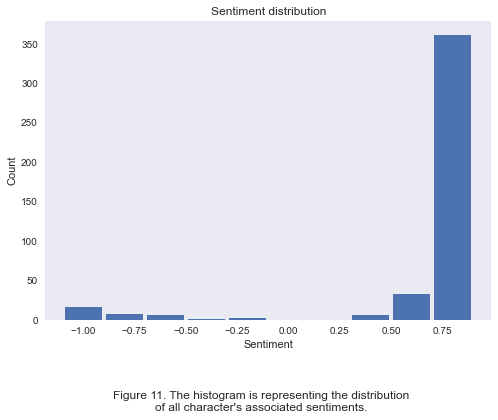

In [438]:
plot_Vader_distribution(V)

The analysis with Vader validates that positive sentiments are more frequently occuring.

    What are the 10 characters with happiest and saddest pages?


In [439]:
#storing the sentiments in a new dataframe
sentiments_df_Vader = pd.DataFrame.from_dict(dict(zelda_graph_Vader.nodes(data=True)), orient='index')
sentiments_df_Vader = sentiments_df_Vader.dropna(subset=['sentiment'])

### 10 happiest characters with Vader

In [440]:
# happiest
sentiments_df_Vader.sort_values(by='sentiment', ascending=False).head(10)

,sentiment
Lonni,0.9999
Nazbi,0.9999
Baddek,0.9999
Galli,0.9999
Paya,0.9999
Cambo,0.9999
Mipha,0.9998
Old Man,0.9998
Brokka,0.9998
Impa,0.9998


### 10 saddest characters with Vader

In [441]:
# saddest
sentiments_df_Vader.sort_values(by='sentiment', ascending=True).head(10)

,sentiment
Princess Zelda,-0.9966
Rik,-0.9949
Dayto,-0.9947
Kotta,-0.9921
Strade,-0.9767
Kotts,-0.9736
Seggin,-0.9689
Russ,-0.9555
Hoz,-0.9498
Garill,-0.9313


## Community sentiments
* <code>What are the three happiest communities according to the LabMT wordlist approach? What about VADER?</code>
* <code>What are the three saddest communities according to the LabMT wordlist approach? What about VADER?</code>
* <code>Create a bar plot showing the average sentiment of each community and add error-bars using the standard deviation for both methods.</code>
* <code>Explain the difference between the two methods and compare the results you have obtained above.</code>
* <code>What is the advantage of using a rule-based method over the dictionary-based approach?</code>

In [442]:
# get the communities with the louvain algorithm
from community import community_louvain
#Randomize is set to false to standardize the results
partition = community_louvain.best_partition(V, randomize=False)

In [443]:
# reverse the dict in order to store all characters in a list under the communities they belong to, which here will be the keys of the dict
from collections import defaultdict
def reverse_dict(partition: dict) -> dict:
    rd = defaultdict(list)
    for k, v in partition.items():
        rd[v].append(k)
    return rd

In [444]:
partition = reverse_dict(partition)

In [445]:
degreeRanking = sorted(V.degree, key=lambda x: x[1], reverse=True)

### Get the 3 most connected characters for each community

In [446]:
#for every community number in the dictionary
def get_name(community_number):
    d = {}
    #looping through the dictionary with the communities
    for name in partition[community_number]:
        #looping through the list of names and degrees
        for elem in degreeRanking:
            if elem[0] == name:
                d[name] = elem[1]
    #extracting the top three names with highest degree
    topthree = (sorted(d.items(), key = lambda x: x[1], reverse = True)[:3])
    #constructing the name
    name = topthree[0][0] + " - " + topthree[1][0] +  " - " + topthree[2][0]
    return name

### Computing the sentiments for all communities with the LabMT approach

In [447]:
#create a dictionary with each character and their community, so the communities can be added to the sentiment dataframe
commList = {}
for comm,char in partition.items():
    for character in char:
        commList[character] = comm

In [448]:
# extending the dataframe by adding the community of each character
sentiments_df["character"] = sentiments_df.index
sentiments_df["community"] = sentiments_df["character"].map(commList)
sentiments_df.reset_index(drop=True, inplace=True)

In [449]:
#grouping the communities and calculate the average sentiment
sentiments_df_avg = sentiments_df.groupby('community').mean()

In [450]:
#sorting the communities from high to low sentiment values
sentiments_df_avg.sort_values(by=['sentiment'], ascending=False)

,sentiment
community,
13,5.950853
0,5.875851
4,5.780872
15,5.774735
14,5.755503
12,5.751315
1,5.744342
3,5.716990
5,5.715843


## Happiest communities LabMT
    What are the three happiest communities according to the LabMT wordlist approach?
The happiest three communities computed with LabMT are number 13, 0 and 4

In [451]:
print("These are the following communities:", get_name(13), ";", get_name(0), ";", get_name(4))

These are the following communities: Chumin - Spinch (Hylian) - Letty ; Baddek - Nazbi - Savelle ; Calamity Ganon - Hylia - Kah Mael


## Saddest communities LabMT
    What are the three saddest communities according to the LabMT wordlist approach?
The saddest three communities computed with LabMT are number 6, 11 and 7

In [452]:
print("These are the following communities:", get_name(6), ";", get_name(11), ";", get_name(7))

These are the following communities: Bokoblin - Lynel - Moblin ; Hinox - Master Kohga - Stone Talus ; Monkton - Harry (Breath of the Wild) - Mary (Breath of the Wild)


## Computing the sentiments for all communities with the Vader approach

In [453]:
#extending the dataframe by adding the community of each character
sentiments_df_Vader["character"] = sentiments_df_Vader.index
sentiments_df_Vader["community"] = sentiments_df_Vader["character"].map(commList)
sentiments_df_Vader.reset_index(drop=True, inplace=True)

In [454]:
#grouping the communities and calculate the average sentiment
sentiments_df_Vader_avg = sentiments_df_Vader.groupby('community').mean()

In [455]:
#sorting the communities from high to low sentiment values
sentiments_df_Vader_avg.sort_values(by=['sentiment'], ascending=False)

,sentiment
community,
0,0.999550
13,0.995300
10,0.929667
2,0.914867
1,0.866900
15,0.856348
17,0.854811
18,0.853873
4,0.844821


## Happiest communities Vader
    What are the three happiest communities according to the VADER wordlist approach?
The happiest three communities computed with Vader are number 0, 13 and 10

In [456]:
print("These are the following communities:", get_name(0), ";", get_name(13), ";", get_name(10))

These are the following communities: Baddek - Nazbi - Savelle ; Chumin - Spinch (Hylian) - Letty ; Ami - Izra - Yolero


### Saddest communities Vader
    What are the three saddest communities according to the VADER wordlist approach?
The saddest three communities computed with Vader are number 3, 19 and 7

In [457]:
print("These are the following communities:", get_name(3), ";", get_name(19), ";", get_name(7))

These are the following communities: Banji - Ena - Chork ; Akrah - Garshon - Onya ; Monkton - Harry (Breath of the Wild) - Mary (Breath of the Wild)


## Bar plots

    Create a bar plot showing the average sentiment of each community and add error-bars using the standard deviation for both methods.


In [458]:
#calculate the sentiment - standard deviation for each community
sentiments_df_std = sentiments_df.groupby('community').std()
sentiments_df_Vader_std = sentiments_df_Vader.groupby('community').std()

### LabMT bar plot

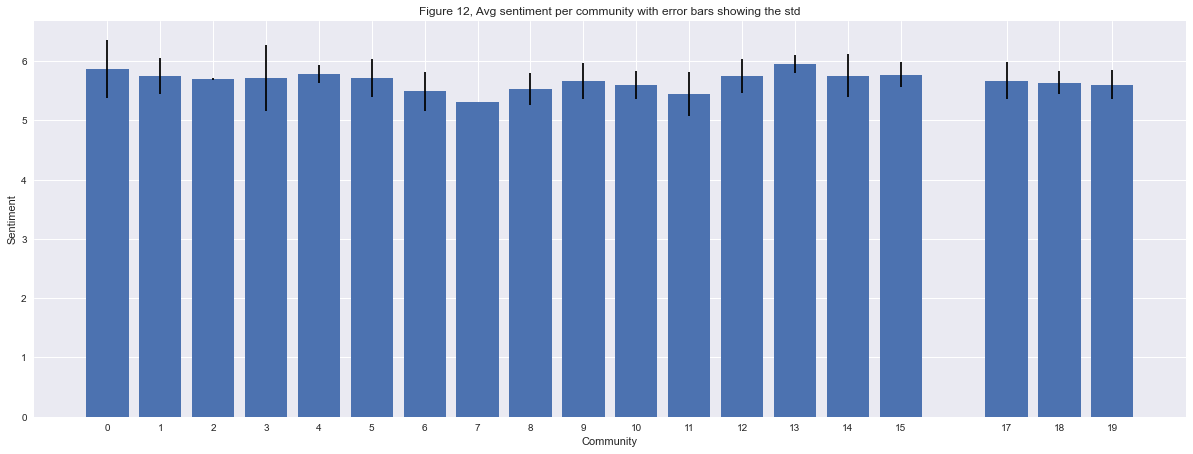

In [459]:
#bar plot with LabMT results
fig = plt.figure()
ax = fig.add_axes([0,0,2,1])
x = sentiments_df_avg.index
y = sentiments_df_avg["sentiment"]
ax.bar(x,y)               
er = errorbar(x,y,sentiments_df_std.sentiment, fmt="none", ecolor="black", capsize=5)
ax.set_xlabel("Community")
ax.set_ylabel("Sentiment")
ax.set_title("Figure 12, Avg sentiment per community with error bars showing the std")
ax.set_xticks(x)
plt.show()

### Vader bar plot

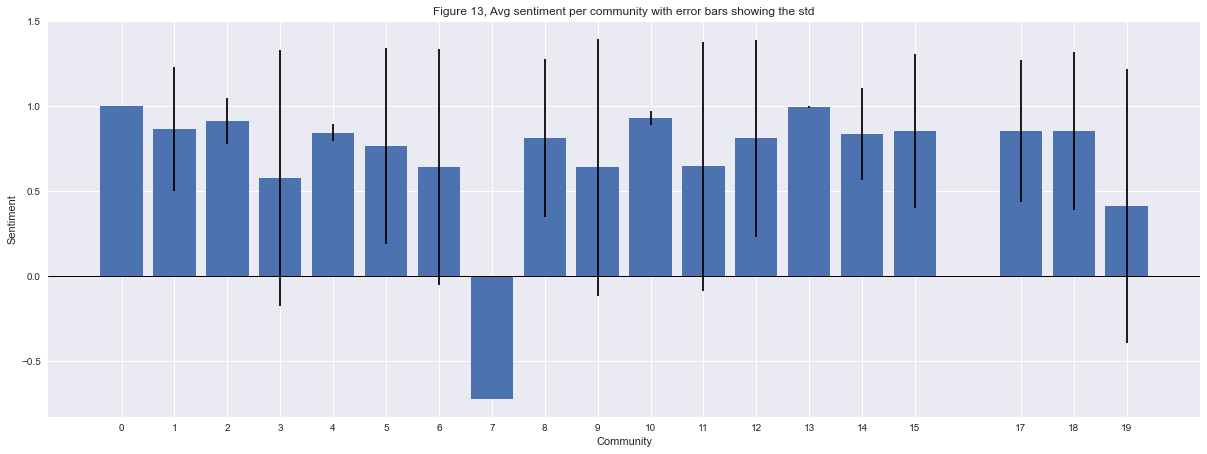

In [460]:
#bar plot with Vader results
fig = plt.figure()
ax = fig.add_axes([0,0,2,1])
x = sentiments_df_Vader_avg.index
y = sentiments_df_Vader_avg["sentiment"]
ax.bar(x,y)               
er = errorbar(x,y,sentiments_df_Vader_std.sentiment, fmt="none", ecolor="black", capsize=5);
ax.set_xlabel("Community")
ax.set_ylabel("Sentiment")
ax.set_title("Figure 13, Avg sentiment per community with error bars showing the std")
ax.set_xticks(x)
plt.axhline(y=0,linewidth=1, color='black')
plt.show()

Due to the standardization of the sentiment values - compound value in Vader method - the scale changes, neutral sentiment lies between -0.05 and 0.05, above means positive and below is negative. The range is high, and the sentiment varies from character to character, which leads to high standard deviations and long error bars. With the LabMT approach most of sentiments are within the 5.5 and 6.5 range leading to narrower standard deviation and shorter error bars.

    Explain the difference between the two methods and compare the results you have obtained above.


The dictionary-based approach computes sentiment based upon a word library, which is storing various words and their corresponding sentiment value. The rule-based approach builds upon that by taking a dictionary as a base and adding a set of rules, which helps to identify a more accurate sentiment by considering things like punctuations, slang or emoticons, shifts in sentences (e.g. a "but", indicating that the polarity in a sentence is changing), capitalized words, which increase sentiment or other words that can increase or decrease the sentiment.

The above visualized results show that the LabMT approach computes the following three communities as the happiest ones:
Chumin - Spinch (Hylian) - Letty ; Baddek - Nazbi - Savelle ; Kass - Genli - Kheel

With Vader slightly different ones are obtained: 
Baddek - Nazbi - Savelle ; Chumin - Spinch (Hylian) - Letty ; Baumar - Falmark - Selmie

Two communities are in both top 3 rankings, LabMT is missing the 3rd community of Vader though, which is ranking on a 9th place and Vader is missing the 3rd LabMT community, which is ranking too on a 9th place.

For the three saddest communities LabMT gets:
Guardian Stalker - Bludo - Yunobo ; Hinox - Master Kohga - Stone Talus ; Monkton - Harry (Breath of the Wild) - Mary (Breath of the Wild)

And Vader:
Banji - Ena - Chork ; Steen - Olkin - Mellie ; Monkton - Harry (Breath of the Wild) - Mary (Breath of the Wild)

Only the last community is matching in the three saddest ones.

    What is the advantage of using a rule-based method over the dictionary-based approach?
The dictionary-based approach relies solely on conducting the analysis with the words provided in the library. If a word is not given, it cannot make any inferences from a text.

The rule-based method includes rules that can change the polarity of the sentiment. I.e., the rules help to adjust the polarity of some words according to their usage in text, for example their relationship to other words or signs. These rules help to detect shifts in polarity or an increased or decreased intensity. Things like capitalized words or exclamation marks can increase intensity. Furthermore, it is better with sentences, so not only single words and it can take into account differences in languages.